<a href="https://colab.research.google.com/github/Preetam314/pytorch_CV/blob/main/CV_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install the Segment Anything Model (SAM) from Meta
!pip install segment-anything
#  Install PyTorch-based segmentation and detection libraries
# YOLOv8 is a modern, easy-to-use option for detection and segmentation
!pip install ultralytics
#  Install pycocotools for processing the COCO dataset (if you choose it)
!pip install pycocotools
#  Install general utility libraries (if not already installed)
!pip install opencv-python Pillow scipy scikit-image

# Deep Learning Framework (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Vision/Image Processing
import numpy as np
import cv2 # OpenCV for image manipulation
from PIL import Image # Python Imaging Library
import matplotlib.pyplot as plt # For visualization

# Data Utilities
import os
import json
from tqdm import tqdm # Progress bar

# Foundation Models (SAM/Segment Anything)
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry # Official SAM library

# Traditional/Modern CV Models (U-Net, YOLO)
# For U-Net, you would typically define the architecture (or use a library like 'segmentation_models.pytorch')
# For YOLOv8, you can import the model directly:
from ultralytics import YOLO

# COCO Dataset Utilities (if using COCO 2017)
# Note: You might need to install pycocotools from the official GitHub if the pip version fails
from pycocotools.coco import COCO
from pycocotools.mask import decode, toBbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# GPU VERIFICATION CELL

# Check Colab's allocated GPU (should show 'Tesla T4' or similar)
!nvidia-smi

# Check if PyTorch can detect a CUDA-enabled GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Tue Nov  4 17:41:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# DOWNLOAD COCO 2017 VALIDATION IMAGES
# This file contains 5,000 validation images
print("Downloading COCO val2017 images (815MB)...")
!wget -q http://images.cocodataset.org/zips/val2017.zip
print("Unzipping images...")
!unzip -q val2017.zip
print("Image download complete. Folder 'val2017' created.")

# Clean up the zip file to save space
!rm val2017.zip

Unzipping images...
replace val2017/000000212226.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace val2017/000000231527.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace val2017/000000578922.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Image download complete. Folder 'val2017' created.


In [ ]:
# DOWNLOAD COCO 2017 ANNOTATIONS
# This file contains the .json files describing the dataset
print("Downloading COCO annotations (241MB)...")
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip
print("Unzipping annotations...")
!unzip -q annotations_trainval2017.zip
print("Annotations download complete. Folder 'annotations' created.")

# Clean up the zip file
!rm annotations_trainval2017.zip

Unzipping annotations...
Annotations download complete. Folder 'annotations' created.


Loading annotations from: ./annotations/instances_val2017.json
loading annotations into memory...
Done (t=0.99s)
creating index...
index created!
Successfully loaded 5000 image annotations.
We will use a subset of 1000 images.


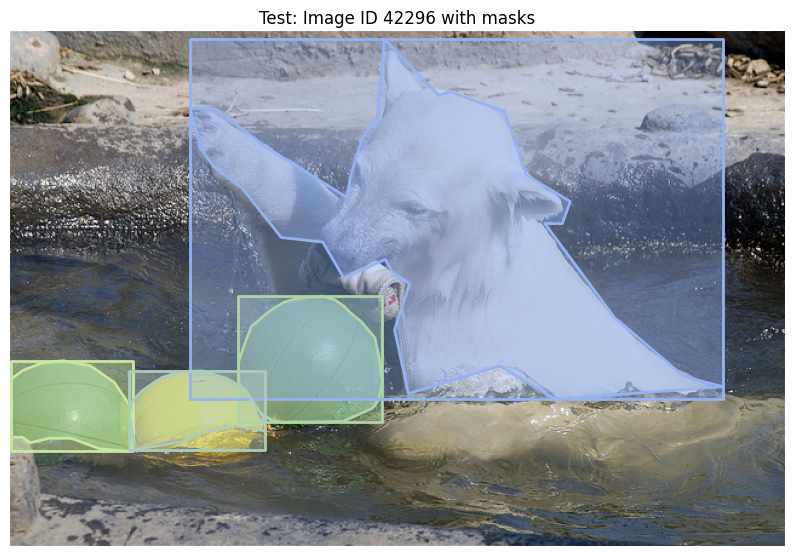

In [ ]:
# LOAD AND VERIFY ANNOTATIONS ---
from pycocotools.coco import COCO
import os
import random

# Define paths
dataDir = '.'
dataType = 'val2017'
annFile = os.path.join(dataDir, 'annotations', f'instances_{dataType}.json')
imgDir = os.path.join(dataDir, dataType)

# Initialize COCO api for instance annotations
print(f"Loading annotations from: {annFile}")
coco = COCO(annFile)

# Get all image IDs
imgIds = coco.getImgIds()
print(f"Successfully loaded {len(imgIds)} image annotations.")

# --- Define our subset ---
# We will just use the first 1000 images to meet the project spec
subset_img_ids = imgIds[:1000]
print(f"We will use a subset of {len(subset_img_ids)} images.")

# --- Test: Load and display a random image from our subset ---
random_img_id = random.choice(subset_img_ids)
img_info = coco.loadImgs([random_img_id])[0]

# Load image
img_path = os.path.join(imgDir, img_info['file_name'])
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load and display annotations
annIds = coco.getAnnIds(imgIds=img_info['id'])
anns = coco.loadAnns(annIds)

plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis('off')
coco.showAnns(anns, draw_bbox=True)
plt.title(f"Test: Image ID {random_img_id} with masks")
plt.show()

In [ ]:
# DEFINE THE CUSTOM COCO DATASET ---

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T

class CocoSegmentationDataset(Dataset):
    def __init__(self, img_dir, coco_api, img_ids, transforms=None):
        self.img_dir = img_dir
        self.coco = coco_api
        self.img_ids = img_ids
        self.transforms = transforms

    def __len__(self):
        # Return the size of our subset
        return len(self.img_ids)

    def __getitem__(self, idx):
        # 1. Get image info
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs([img_id])[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        # 2. Load image
        # Open with PIL for easier transform compatibility
        image = Image.open(img_path).convert("RGB")

        # 3. Load all annotations for this image
        ann_ids = self.coco.getAnnIds(imgIds=img_info['id'])
        anns = self.coco.loadAnns(ann_ids)

        # 4. Create a single combined binary mask
        # Start with an empty mask (all background)
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

        # Iterate over all annotations and "draw" them onto the mask
        for ann in anns:
            # coco.annToMask returns a binary mask for ONE annotation
            mask = np.maximum(mask, self.coco.annToMask(ann))

        # Convert numpy mask to PIL Image (so transforms can be applied)
        mask = Image.fromarray(mask)

        # 5. Apply transforms (if any)
        if self.transforms is not None:
            image, mask = self.transforms(image, mask)

        return image, mask

print("Custom Dataset class 'CocoSegmentationDataset' defined.")

Custom Dataset class 'CocoSegmentationDataset' defined.


In [ ]:
#  DEFINE TRANSFORMS AND CREATE DATALOADER ---

# Define the image transformations
# We need to apply the same geometric transforms (like Resize) to BOTH
# the image and the mask, but normalization ONLY to the image.

IMG_SIZE = 256

# Define transforms
def get_transforms():
    class ResizeAndToTensor:
        def __call__(self, image, mask):
            # 1. Resize
            image = T.functional.resize(image, (IMG_SIZE, IMG_SIZE))
            # Use NEAREST neighbor for masks to keep 0/1 values sharp
            mask = T.functional.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=T.InterpolationMode.NEAREST)

            # 2. Convert Image to Tensor (and scale)
            image = T.functional.to_tensor(image)

            # 3. Convert Mask to Tensor (MANUALLY to avoid scaling)
            # Convert PIL mask to numpy array (H, W)
            mask_np = np.array(mask)
            # Add a channel dimension (H, W) -> (1, H, W)
            mask_np = np.expand_dims(mask_np, axis=0)
            # Convert numpy array to tensor (values 0 & 1 are preserved)
            # and cast to float, as required by the loss function
            mask = torch.from_numpy(mask_np).float()

            # 4. Normalize Image
            image = T.functional.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

            return image, mask

    return ResizeAndToTensor()

# --- Create the Dataset and DataLoader ---

# Use the 'subset_img_ids' (our 1000 images) from Cell 5
train_dataset = CocoSegmentationDataset(
    img_dir=imgDir,
    coco_api=coco,
    img_ids=subset_img_ids,
    transforms=get_transforms()
)

# Create the DataLoader
# This will feed data to our model in batches of 8
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)

print(f"Created a training dataset with {len(train_dataset)} images.")
print("Created 'train_loader' to feed batches of 8 images/masks to the model.")

# --- Test the DataLoader ---
# Let's grab one batch and check its shape
try:
    images, masks = next(iter(train_loader))
    print(f"\nSuccessfully loaded one batch:")
    print(f"Images batch shape: {images.shape}") # [BatchSize, Channels, Height, Width]
    print(f"Masks batch shape: {masks.shape}")   # [BatchSize, 1, Height, Width]
    print(f"Masks data type: {masks.dtype}")
    print(f"Mask min/max: {masks.min()}, {masks.max()}") # Should be 0.0 and 1.0
except Exception as e:
    print(f"\nError loading batch: {e}")
    print("This can sometimes happen on the first run, try re-running this cell.")

Created a training dataset with 1000 images.
Created 'train_loader' to feed batches of 8 images/masks to the model.

Successfully loaded one batch:
Images batch shape: torch.Size([8, 3, 256, 256])
Masks batch shape: torch.Size([8, 1, 256, 256])
Masks data type: torch.float32
Mask min/max: 0.0, 1.0


In [ ]:
# DEFINE THE U-NET ARCHITECTURE ---

# First, define the building block: a double convolution layer
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Define the U-Net Model
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Encoder (Down-path)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = (DoubleConv(64, 128), nn.MaxPool2d(2))
        self.down2 = (DoubleConv(128, 256), nn.MaxPool2d(2))
        self.down3 = (DoubleConv(256, 512), nn.MaxPool2d(2))
        self.down4 = (DoubleConv(512, 1024), nn.MaxPool2d(2))

        # Decoder (Up-path)
        # Note: Up-conv + skip connection concatenation
        self.up1 = (nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2), DoubleConv(1024, 512))
        self.up2 = (nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2), DoubleConv(512, 256))
        self.up3 = (nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), DoubleConv(256, 128))
        self.up4 = (nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), DoubleConv(128, 64))

        # Final output convolution
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

        # Register modules to make them accessible
        self.d1 = nn.Sequential(*self.down1)
        self.d2 = nn.Sequential(*self.down2)
        self.d3 = nn.Sequential(*self.down3)
        self.d4 = nn.Sequential(*self.down4)
        self.u1 = nn.ModuleList(self.up1)
        self.u2 = nn.ModuleList(self.up2)
        self.u3 = nn.ModuleList(self.up3)
        self.u4 = nn.ModuleList(self.up4)


    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.d1(x1)
        x3 = self.d2(x2)
        x4 = self.d3(x3)
        x5 = self.d4(x4) # Bottleneck

        # Decoder + Skip Connections
        x = self.u1[0](x5) # Up-conv
        x = torch.cat([x, x4], dim=1) # Skip connection
        x = self.u1[1](x) # DoubleConv

        x = self.u2[0](x)
        x = torch.cat([x, x3], dim=1)
        x = self.u2[1](x)

        x = self.u3[0](x)
        x = torch.cat([x, x2], dim=1)
        x = self.u3[1](x)

        x = self.u4[0](x)
        x = torch.cat([x, x1], dim=1)
        x = self.u4[1](x)

        # Final output
        logits = self.outc(x)
        return logits

print("U-Net model architecture defined.")




U-Net model architecture defined.


In [ ]:
#  INITIALIZE MODEL AND LOSSES ---

# 1. Initialize a NEW model (to restart training)
model = UNet(n_channels=3, n_classes=1).to(device)

# 2. Define BCE Loss (as before)
bce_criterion = nn.BCEWithLogitsLoss()

# 3. Define Dice Loss (better for imbalance)
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        # Apply sigmoid to model logits
        preds = torch.sigmoid(preds)

        # Flatten tensors
        preds_flat = preds.view(-1)
        targets_flat = targets.view(-1)

        # Calculate intersection and union
        intersection = (preds_flat * targets_flat).sum()
        total = (preds_flat + targets_flat).sum()

        # Calculate Dice coefficient
        dice_coeff = (2. * intersection + self.smooth) / (total + self.smooth)

        # Return Dice Loss
        return 1 - dice_coeff

dice_criterion = DiceLoss().to(device)

# 4. Define the Optimizer (as before)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print(f"Model re-initialized on {device}.")
print("Using COMBINED loss: BCEWithLogitsLoss + DiceLoss")

Model re-initialized on cuda:0.
Using COMBINED loss: BCEWithLogitsLoss + DiceLoss


In [ ]:
# DEFINE METRIC FUNCTION (IoU) ---

def calculate_iou(preds, targets, threshold=0.5):
    """
    Calculates the Intersection over Union (IoU) metric, also known as
    the Jaccard index. For binary segmentation, this is often used.

    preds: Model outputs (logits)
    targets: Ground truth masks (0.0 or 1.0)
    """
    # 1. Apply sigmoid to logits and threshold to get binary predictions
    preds_binary = (torch.sigmoid(preds) > threshold).float()

    # 2. Flatten tensors
    preds_flat = preds_binary.view(-1)
    targets_flat = targets.view(-1)

    # 3. Calculate Intersection and Union
    intersection = (preds_flat * targets_flat).sum()
    total = (preds_flat + targets_flat).sum()
    union = total - intersection

    # 4. Calculate IoU (add 1e-6 to avoid division by zero)
    iou = (intersection + 1e-6) / (union + 1e-6)

    return iou

print("Helper function 'calculate_iou' defined.")

Helper function 'calculate_iou' defined.


In [ ]:
#  TRAINING LOOP WITH COMBINED LOSS ---

from tqdm import tqdm

# --- Hyperparameters ---
NUM_EPOCHS = 30 # Increased epochs

print(f"--- Starting Training on {device} for {NUM_EPOCHS} Epochs ---")

train_loss_history = []
train_iou_history = []

for epoch in range(NUM_EPOCHS):
    model.train()

    running_loss = 0.0
    running_iou = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

    for i, (images, masks) in enumerate(progress_bar):

        images = images.to(device)
        masks = masks.to(device)

        # 1. Forward pass
        outputs = model(images)

        # 2. Calculate COMBINED loss
        bce_loss = bce_criterion(outputs, masks)
        dice_loss = dice_criterion(outputs, masks)
        loss = bce_loss + dice_loss # <--- THE FIX!

        # 3. Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 4. Update running metrics
        running_loss += loss.item()
        running_iou += calculate_iou(outputs.detach(), masks.detach()).item()

        progress_bar.set_postfix({'loss': running_loss / (i + 1), 'iou': running_iou / (i + 1)})

    epoch_loss = running_loss / len(train_loader)
    epoch_iou = running_iou / len(train_loader)

    train_loss_history.append(epoch_loss)
    train_iou_history.append(epoch_iou)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {epoch_loss:.4f}, IoU: {epoch_iou:.4f}")

print("--- Training Complete ---")

--- Starting Training on cuda:0 for 30 Epochs ---


Epoch 1/30: 100%|██████████| 125/125 [01:39<00:00,  1.25it/s, loss=1.15, iou=0.366]


Epoch 1/30, Loss: 1.1497, IoU: 0.3659


Epoch 2/30: 100%|██████████| 125/125 [01:39<00:00,  1.25it/s, loss=1.06, iou=0.418]


Epoch 2/30, Loss: 1.0584, IoU: 0.4178


Epoch 3/30: 100%|██████████| 125/125 [01:39<00:00,  1.26it/s, loss=1.02, iou=0.438]


Epoch 3/30, Loss: 1.0181, IoU: 0.4382


Epoch 4/30: 100%|██████████| 125/125 [01:39<00:00,  1.25it/s, loss=0.995, iou=0.442]


Epoch 4/30, Loss: 0.9952, IoU: 0.4425


Epoch 5/30: 100%|██████████| 125/125 [01:39<00:00,  1.25it/s, loss=0.981, iou=0.45]


Epoch 5/30, Loss: 0.9813, IoU: 0.4504


Epoch 6/30: 100%|██████████| 125/125 [01:39<00:00,  1.25it/s, loss=0.964, iou=0.458]


Epoch 6/30, Loss: 0.9645, IoU: 0.4575


Epoch 7/30: 100%|██████████| 125/125 [01:39<00:00,  1.25it/s, loss=0.95, iou=0.465]


Epoch 7/30, Loss: 0.9496, IoU: 0.4647


Epoch 8/30: 100%|██████████| 125/125 [01:39<00:00,  1.25it/s, loss=0.948, iou=0.468]


Epoch 8/30, Loss: 0.9476, IoU: 0.4680


Epoch 9/30: 100%|██████████| 125/125 [01:39<00:00,  1.25it/s, loss=0.926, iou=0.475]


Epoch 9/30, Loss: 0.9262, IoU: 0.4752


Epoch 10/30: 100%|██████████| 125/125 [01:39<00:00,  1.25it/s, loss=0.914, iou=0.486]


Epoch 10/30, Loss: 0.9142, IoU: 0.4855


Epoch 11/30: 100%|██████████| 125/125 [01:39<00:00,  1.25it/s, loss=0.908, iou=0.488]


Epoch 11/30, Loss: 0.9077, IoU: 0.4884


Epoch 12/30: 100%|██████████| 125/125 [01:40<00:00,  1.25it/s, loss=0.899, iou=0.495]


Epoch 12/30, Loss: 0.8987, IoU: 0.4953


Epoch 13/30: 100%|██████████| 125/125 [01:40<00:00,  1.25it/s, loss=0.897, iou=0.494]


Epoch 13/30, Loss: 0.8968, IoU: 0.4938


Epoch 14/30: 100%|██████████| 125/125 [01:39<00:00,  1.26it/s, loss=0.905, iou=0.489]


Epoch 14/30, Loss: 0.9047, IoU: 0.4886


Epoch 15/30: 100%|██████████| 125/125 [01:39<00:00,  1.25it/s, loss=0.867, iou=0.505]


Epoch 15/30, Loss: 0.8672, IoU: 0.5052


Epoch 16/30: 100%|██████████| 125/125 [01:40<00:00,  1.25it/s, loss=0.874, iou=0.5]


Epoch 16/30, Loss: 0.8744, IoU: 0.5002


Epoch 17/30: 100%|██████████| 125/125 [01:39<00:00,  1.26it/s, loss=0.863, iou=0.508]


Epoch 17/30, Loss: 0.8625, IoU: 0.5083


Epoch 18/30: 100%|██████████| 125/125 [01:40<00:00,  1.25it/s, loss=0.859, iou=0.511]


Epoch 18/30, Loss: 0.8590, IoU: 0.5113


Epoch 19/30: 100%|██████████| 125/125 [01:39<00:00,  1.25it/s, loss=0.838, iou=0.522]


Epoch 19/30, Loss: 0.8383, IoU: 0.5216


Epoch 20/30: 100%|██████████| 125/125 [01:39<00:00,  1.26it/s, loss=0.835, iou=0.522]


Epoch 20/30, Loss: 0.8353, IoU: 0.5218


Epoch 21/30: 100%|██████████| 125/125 [01:39<00:00,  1.25it/s, loss=0.819, iou=0.529]


Epoch 21/30, Loss: 0.8191, IoU: 0.5294


Epoch 22/30: 100%|██████████| 125/125 [01:39<00:00,  1.25it/s, loss=0.81, iou=0.539]


Epoch 22/30, Loss: 0.8104, IoU: 0.5386


Epoch 23/30: 100%|██████████| 125/125 [01:39<00:00,  1.25it/s, loss=0.791, iou=0.55]


Epoch 23/30, Loss: 0.7914, IoU: 0.5500


Epoch 24/30: 100%|██████████| 125/125 [01:40<00:00,  1.25it/s, loss=0.788, iou=0.548]


Epoch 24/30, Loss: 0.7880, IoU: 0.5479


Epoch 25/30: 100%|██████████| 125/125 [01:39<00:00,  1.25it/s, loss=0.778, iou=0.551]


Epoch 25/30, Loss: 0.7778, IoU: 0.5511


Epoch 26/30: 100%|██████████| 125/125 [01:39<00:00,  1.25it/s, loss=0.751, iou=0.57]


Epoch 26/30, Loss: 0.7509, IoU: 0.5701


Epoch 27/30: 100%|██████████| 125/125 [01:39<00:00,  1.25it/s, loss=0.726, iou=0.581]


Epoch 27/30, Loss: 0.7263, IoU: 0.5807


Epoch 28/30: 100%|██████████| 125/125 [01:39<00:00,  1.25it/s, loss=0.728, iou=0.58]


Epoch 28/30, Loss: 0.7282, IoU: 0.5799


Epoch 29/30: 100%|██████████| 125/125 [01:40<00:00,  1.25it/s, loss=0.694, iou=0.599]


Epoch 29/30, Loss: 0.6940, IoU: 0.5990


Epoch 30/30: 100%|██████████| 125/125 [01:40<00:00,  1.25it/s, loss=0.677, iou=0.608]

Epoch 30/30, Loss: 0.6765, IoU: 0.6084
--- Training Complete ---


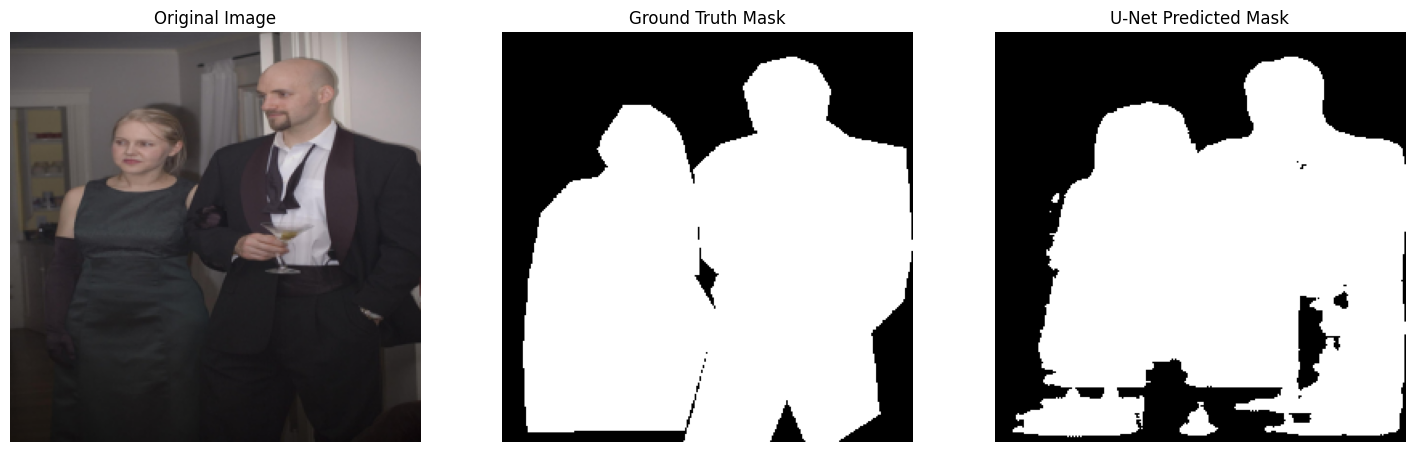

In [ ]:
# VISUALIZE U-NET PREDICTIONS ---

import torchvision.transforms.functional as TF

# 1. Set model to evaluation mode (disables dropout, batchnorm updates, etc.)
model.eval()

# 2. Get a test batch from the dataloader
with torch.no_grad(): # Disable gradient calculation for inference
    # Let's get a batch
    images, masks = next(iter(train_loader))

    # Pick one image from the batch (e.g., the first one)
    test_image = images[0:1].to(device) # Keep batch dim [1, C, H, W]
    true_mask = masks[0:1].to(device) # Keep batch dim [1, 1, H, W]

    # 3. Get model prediction (output is logits)
    pred_logits = model(test_image)

    # 4. Process the prediction
    # Apply sigmoid to get probabilities (0.0 to 1.0)
    pred_probs = torch.sigmoid(pred_logits)
    # Apply a threshold to get a binary mask (0.0 or 1.0)
    pred_mask = (pred_probs > 0.5).float()

    # 5. Move tensors to CPU and convert to NumPy for plotting
    test_image_cpu = test_image.cpu().squeeze(0) # Remove batch dim
    true_mask_cpu = true_mask.cpu().squeeze(0)   # Remove batch dim
    pred_mask_cpu = pred_mask.cpu().squeeze(0)   # Remove batch dim

    # --- De-normalize the image for correct display ---
    # We need to reverse the normalization applied in the dataloader
    # Mean = [0.485, 0.456, 0.406], Std = [0.229, 0.224, 0.225]
    inv_normalize = T.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img_display = inv_normalize(test_image_cpu)

    # Convert from tensor [C, H, W] to numpy [H, W, C] for plt.imshow
    img_display = img_display.permute(1, 2, 0).numpy()
    true_mask_display = true_mask_cpu.permute(1, 2, 0).numpy()
    pred_mask_display = pred_mask_cpu.permute(1, 2, 0).numpy()

    # Clip values to [0, 1] just in case of numerical instability
    img_display = np.clip(img_display, 0, 1)

    # 6. Plot the results
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    ax[0].imshow(img_display)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(true_mask_display, cmap='gray')
    ax[1].set_title("Ground Truth Mask")
    ax[1].axis('off')

    ax[2].imshow(pred_mask_display, cmap='gray')
    ax[2].set_title("U-Net Predicted Mask")
    ax[2].axis('off')

    plt.show()

In [ ]:
# SAVE THE TRAINED MODEL WEIGHTS ---

# Define a path to save the model
MODEL_SAVE_PATH = "unet_coco_subset.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), MODEL_SAVE_PATH)

print(f"Model state dictionary saved to: {MODEL_SAVE_PATH}")

Model state dictionary saved to: unet_coco_subset.pth


In [ ]:
# : DOWNLOAD SAM CHECKPOINT ---

print("Downloading the SAM (ViT-Base) model checkpoint (375MB)...")
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
print("Download complete.")

Download complete.


In [ ]:
#  INITIALIZE SAM (FOUNDATION MODEL) ---

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# --- Configuration ---
SAM_CHECKPOINT = "sam_vit_b_01ec64.pth"
MODEL_TYPE = "vit_b"
# ---------------------

print("Loading SAM model... This may take a moment.")
# 1. Load the model architecture
sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT)

# 2. Move the model to the GPU
sam.to(device=device)

# 3. Initialize the AutomaticMaskGenerator
# This is our "zero-shot" segmentation tool
mask_generator = SamAutomaticMaskGenerator(sam)

print(f"SAM model '{MODEL_TYPE}' loaded and moved to {device}.")
print("Initialized SamAutomaticMaskGenerator for zero-shot inference.")

Loading SAM model... This may take a moment.
SAM model 'vit_b' loaded and moved to cuda:0.
Initialized SamAutomaticMaskGenerator for zero-shot inference.


Loading original image: 000000397133.jpg
Running SAM...
SAM found 112 potential objects/masks.


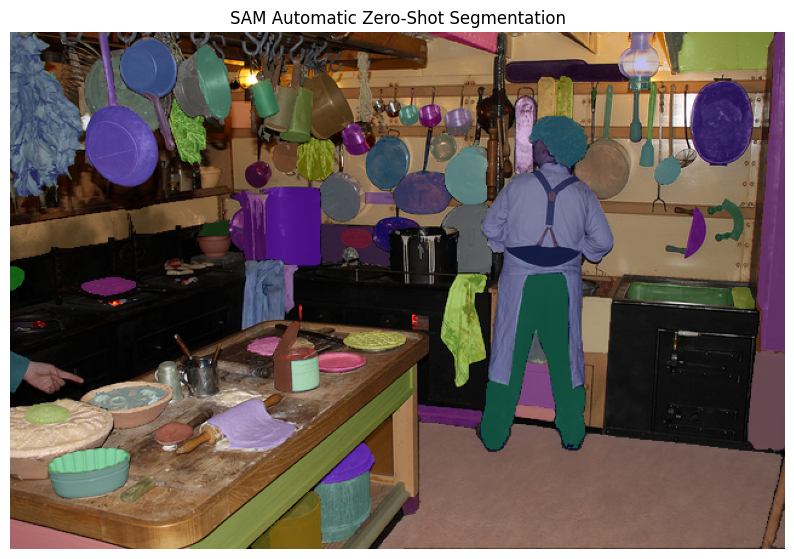

In [ ]:
# RUN ZERO-SHOT INFERENCE WITH SAM ---

# Helper function to plot SAM's output
def show_sam_anns(anns, ax):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35))) # Show colored mask

# --- Get an original image to test ---
# Let's use the first image from our subset for a consistent test
test_img_id = subset_img_ids[0] # From Cell 5
img_info = coco.loadImgs([test_img_id])[0]
img_path = os.path.join(imgDir, img_info['file_name'])

print(f"Loading original image: {img_info['file_name']}")
# SAM expects a standard OpenCV/NumPy image (H, W, C)
image_bgr = cv2.imread(img_path)

# --- FIX IS HERE ---
# It's cv2.COLOR_BGR2RGB (with a 2), not cv2.COLOR_BGR_RGB
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
# -------------------

# --- Run SAM ---
# This is the "zero-shot" inference step.
print("Running SAM...")
sam_masks = mask_generator.generate(image_rgb)
print(f"SAM found {len(sam_masks)} potential objects/masks.")

# --- Plot SAM's output ---
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
show_sam_anns(sam_masks, plt.gca())
plt.title("SAM Automatic Zero-Shot Segmentation")
plt.axis('off')
plt.show()

In [ ]:
# INITIALIZE SAM PREDICTOR ---

from segment_anything import SamPredictor

# We use the 'sam' model we already loaded onto the GPU
predictor = SamPredictor(sam)

print("SamPredictor initialized and ready.")

SamPredictor initialized and ready.


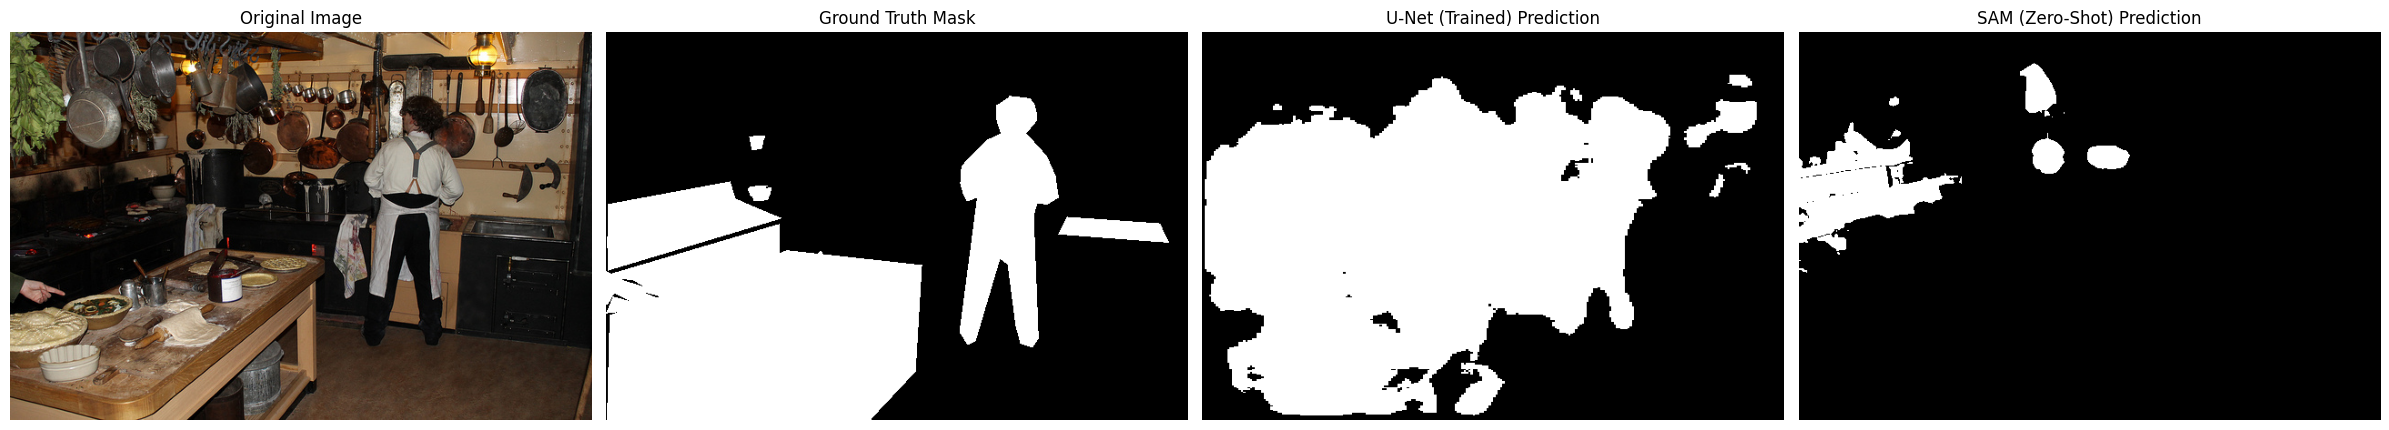

Comparison cell complete (Corrected).


In [ ]:
# SIDE-BY-SIDE COMPARISON (U-NET vs. SAM) ---

# 1. --- SETUP: Choose ONE image to test ---
# We'll use the first image from our subset (the kitchen scene)
test_img_id = subset_img_ids[0]
img_info = coco.loadImgs([test_img_id])[0]
img_path = os.path.join(imgDir, img_info['file_name'])

# 2. --- LOAD ORIGINAL IMAGE AND MASK ---
# Load original image in two formats (PIL for U-Net, RGB for SAM/plotting)
image_pil = Image.open(img_path).convert("RGB")
image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Load Ground Truth annotations
ann_ids = coco.getAnnIds(imgIds=img_info['id'])
anns = coco.loadAnns(ann_ids)

# Create the full Ground Truth mask for plotting
gt_mask_coco = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
for ann in anns:
    gt_mask_coco = np.maximum(gt_mask_coco, coco.annToMask(ann))

# 3. --- A) RUN U-NET PREDICTION (on this specific image) ---
model.eval() # Set U-Net to eval mode

# Get the transform function from CELL 7
transform_fn = get_transforms()

# Apply the same transforms U-Net was trained on
# We pass a dummy mask_pil because the transform function expects two args
mask_pil_dummy = Image.fromarray(np.zeros((img_info['height'], img_info['width']), dtype=np.uint8))
image_tensor, _ = transform_fn(image_pil, mask_pil_dummy)

# Add batch dimension [C, H, W] -> [1, C, H, W] and send to GPU
image_tensor = image_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    # Get U-Net's prediction
    pred_logits_unet = model(image_tensor)
    pred_mask_unet = (torch.sigmoid(pred_logits_unet) > 0.5).float()

# Resize U-Net's prediction back to original size for comparison
unet_pred_resized = TF.resize(
    pred_mask_unet.cpu(),
    (img_info['height'], img_info['width']),
    interpolation=T.InterpolationMode.NEAREST
).squeeze().numpy() # Squeeze to [H, W]

# 4. --- B) RUN SAM PREDICTION (on this specific image) ---
predictor.set_image(image_rgb) # Set image for SAM

# Get COCO bounding boxes [x, y, w, h] as prompts
input_boxes = [ann['bbox'] for ann in anns]
sam_boxes = []
for box in input_boxes:
    x, y, w, h = box; sam_boxes.append([x, y, x + w, y + h])

input_boxes_tensor = torch.tensor(sam_boxes, device=predictor.device)

# Run SAM with box prompts
sam_masks, _, _ = predictor.predict_torch(
    point_coords=None, point_labels=None,
    boxes=input_boxes_tensor,
    multimask_output=False,
)

# Combine all of SAM's masks into one
sam_combined_mask, _ = torch.max(sam_masks, dim=0)
sam_combined_mask = sam_combined_mask.float()

# 5. --- C) PLOT ALL FOUR ---
fig, ax = plt.subplots(1, 4, figsize=(24, 8))

ax[0].imshow(image_rgb)
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(gt_mask_coco, cmap='gray')
ax[1].set_title("Ground Truth Mask")
ax[1].axis('off')

ax[2].imshow(unet_pred_resized, cmap='gray')
ax[2].set_title("U-Net (Trained) Prediction")
ax[2].axis('off')

ax[3].imshow(sam_combined_mask.cpu().squeeze().numpy(), cmap='gray')
ax[3].set_title("SAM (Zero-Shot) Prediction")
ax[3].axis('off')

plt.tight_layout()
plt.show()

print("Comparison cell complete (Corrected).")

In [ ]:
#  DEFINE ALL METRIC FUNCTIONS ---

def calculate_metrics(preds, targets, threshold=0.5):
    """Calculates IoU, Precision, Recall, and F1 Score"""
    # 1. Apply sigmoid and threshold
    preds_binary = (torch.sigmoid(preds) > threshold).float()

    # 2. Flatten tensors
    preds_flat = preds_binary.view(-1).cpu()
    targets_flat = targets.view(-1).cpu()

    # 3. Calculate TP, FP, FN
    tp = (preds_flat * targets_flat).sum()
    fp = preds_flat.sum() - tp
    fn = targets_flat.sum() - tp

    # 4. Calculate Metrics (add 1e-6 to avoid division by zero)
    iou = (tp + 1e-6) / (tp + fp + fn + 1e-6)
    precision = (tp + 1e-6) / (tp + fp + 1e-6)
    recall = (tp + 1e-6) / (tp + fn + 1e-6)

    # --- THIS IS THE FIX ---
    # Calculate F1 directly from TP, FP, FN. It's more stable.
    f1 = (2 * tp + 1e-6) / (2 * tp + fp + fn + 1e-6)

    return iou.item(), precision.item(), recall.item(), f1.item()

print("Corrected metric functions (IoU, Precision, Recall, F1) defined.")

Corrected metric functions (IoU, Precision, Recall, F1) defined.


In [ ]:
#  CREATE EVALUATION DATALOADER ---

# We re-use the 'train_dataset' we already created
eval_loader = DataLoader(
    train_dataset,
    batch_size=1, # Process one image at a time
    shuffle=False, # Go in order
    num_workers=2
)

print(f"Created 'eval_loader' with {len(eval_loader)} images (batch size 1).")

Created 'eval_loader' with 1000 images (batch size 1).


In [ ]:
# - FINAL EVALUATION LOOP (U-NET vs. SAM) ---

# 1. Set models to evaluation mode
model.eval() # U-Net
predictor.set_image(np.zeros((1,1,3), dtype=np.uint8)) # Init SAM predictor

# 2. Metric accumulators
unet_metrics = {'iou': [], 'precision': [], 'recall': [], 'f1': []}
sam_metrics = {'iou': [], 'precision': [], 'recall': [], 'f1': []}

print("Starting final evaluation... This will take several minutes.")

# Use tqdm for a progress bar
for i, (image_tensor, true_mask_tensor) in enumerate(tqdm(eval_loader)):

    # --- A. GET U-NET PREDICTION ---
    # Data is already on CPU from loader, move to GPU for model
    image_tensor_gpu = image_tensor.to(device)
    true_mask_gpu = true_mask_tensor.to(device)

    with torch.no_grad():
        unet_logits = model(image_tensor_gpu)

    # Calculate U-Net metrics against the 256x256 ground truth
    unet_iou, unet_p, unet_r, unet_f1 = calculate_metrics(unet_logits.cpu(), true_mask_tensor)
    unet_metrics['iou'].append(unet_iou)
    unet_metrics['precision'].append(unet_p)
    unet_metrics['recall'].append(unet_r)
    unet_metrics['f1'].append(unet_f1)

    # --- B. GET SAM PREDICTION ---

    # 1. Get original image info
    img_id = subset_img_ids[i] # Get the i-th ID since shuffle=False
    img_info = coco.loadImgs([img_id])[0]
    img_path = os.path.join(imgDir, img_info['file_name'])

    # 2. Load original image for SAM
    image_bgr = cv2.imread(img_path)
    if image_bgr is None: continue # Skip if image is bad
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # 3. Set SAM image
    predictor.set_image(image_rgb)

    # 4. Get box prompts
    ann_ids = coco.getAnnIds(imgIds=img_info['id'])
    anns = coco.loadAnns(ann_ids)
    if not anns: continue # Skip if no annotations

    input_boxes = [ann['bbox'] for ann in anns]
    sam_boxes = []
    for box in input_boxes:
        x, y, w, h = box; sam_boxes.append([x, y, x + w, y + h])

    input_boxes_tensor = torch.tensor(sam_boxes, device=predictor.device)

    # 5. Run SAM predictor
    with torch.no_grad():
        sam_masks, _, _ = predictor.predict_torch(
            point_coords=None, point_labels=None,
            boxes=input_boxes_tensor,
            multimask_output=False,
        )

    # 6. Combine SAM masks and resize to match ground truth tensor (256x256)
    sam_combined_mask, _ = torch.max(sam_masks, dim=0)
    sam_combined_mask = sam_combined_mask.unsqueeze(0) # [1, H, W]

    # Resize!
    sam_pred_resized = TF.resize(
        sam_combined_mask.float(),
        (IMG_SIZE, IMG_SIZE), # (256, 256)
        interpolation=T.InterpolationMode.NEAREST
    ).cpu() # [1, 256, 256]

    # --- C. CALCULATE SAM METRICS ---
    # We use sigmoid on SAM's output just to make the metric function happy
    # (it expects logits, but SAM's output is 0/1, so sigmoid(10) is ~1)
    sam_iou, sam_p, sam_r, sam_f1 = calculate_metrics(sam_pred_resized * 10, true_mask_tensor)
    sam_metrics['iou'].append(sam_iou)
    sam_metrics['precision'].append(sam_p)
    sam_metrics['recall'].append(sam_r)
    sam_metrics['f1'].append(sam_f1)

print("--- Evaluation Complete ---")

Starting final evaluation... This will take several minutes.


100%|██████████| 1000/1000 [08:14<00:00,  2.02it/s]

--- Evaluation Complete ---


In [ ]:
#  PRINT FINAL RESULTS TABLE ---

# Calculate averages
avg_unet_iou = np.mean(unet_metrics['iou'])
avg_unet_precision = np.mean(unet_metrics['precision'])
avg_unet_recall = np.mean(unet_metrics['recall'])
avg_unet_f1 = np.mean(unet_metrics['f1'])

avg_sam_iou = np.mean(sam_metrics['iou'])
avg_sam_precision = np.mean(sam_metrics['precision'])
avg_sam_recall = np.mean(sam_metrics['recall'])
avg_sam_f1 = np.mean(sam_metrics['f1'])

# Print the table
print("--- Comparative Results (Averaged over 1000 images) ---")
print("---------------------------------------------------------")
print(f"| Metric      | U-Net (Trained) | SAM (Zero-Shot) |")
print(f"|-------------|-----------------|-----------------|")
print(f"| mIoU / Dice | {avg_unet_iou:<15.4f} | {avg_sam_iou:<15.4f} |")
print(f"| Precision   | {avg_unet_precision:<15.4f} | {avg_sam_precision:<15.4f} |")
print(f"| Recall      | {avg_unet_recall:<15.4f} | {avg_sam_recall:<15.4f} |")
print(f"| F1-Score    | {avg_unet_f1:<15.4f} | {avg_sam_f1:<15.4f} |")
print("---------------------------------------------------------")

--- Comparative Results (Averaged over 1000 images) ---
---------------------------------------------------------
| Metric      | U-Net (Trained) | SAM (Zero-Shot) |
|-------------|-----------------|-----------------|
| mIoU / Dice | 0.5799          | 0.0458          |
| Precision   | 0.6843          | 0.3061          |
| Recall      | 0.7914          | 0.0490          |
| F1-Score    | 0.7007          | 0.0818          |
---------------------------------------------------------
